In [1]:
import pandas as pd
import numpy as np
import multiprocessing
from bs4 import BeautifulSoup as bs
from selectolax.parser import HTMLParser
import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

from time import time  # To time our operations
from collections import defaultdict  # For word frequency

# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Data loading and preparation
data = pd.read_json('../datasets/dataset.json')
mapping = {False: 0, True: 1}
data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['violation'], axis=1, inplace=True)
data.shape

(86439, 2)

In [4]:
data.head()

,text,labels
0,My Favorite Slut,0
1,girlfriends sit on each other's faces with the...,0
2,bound beauty kisses her girlfriend,0
3,MORGAN - Anytime - Nail Painting On The Slave'...,0
4,TRANSGENDER COACHING (wmv) PART 1,0


# Tokenization

In [5]:
text = data.iloc[10]['text']

In [6]:
text

'MORGAN - Anytime - Lick My Sexy Mules Clean! - Shoe Worship And Domination'

In [7]:
tokens = word_tokenize(text.lower())

In [8]:
tokens

['morgan',
 '-',
 'anytime',
 '-',
 'lick',
 'my',
 'sexy',
 'mules',
 'clean',
 '!',
 '-',
 'shoe',
 'worship',
 'and',
 'domination']

# Punctuation filtering

In [9]:
punctuation_marks = ['!', ',', ';', '(', ')', ':', '-', '--', '', '?', '@', '....',
                     '.', '..', '...', '<', '>', '=', '\'\'', '//', '»', '|',
                     '\"\"', '</', '&', '/', '#', '\'', '*', '``', '%', '[', ']', '{', '}']

In [10]:
only_words = []
for token in tokens:
    if token not in punctuation_marks:
        only_words.append(token)

In [11]:
only_words

['morgan',
 'anytime',
 'lick',
 'my',
 'sexy',
 'mules',
 'clean',
 'shoe',
 'worship',
 'and',
 'domination']

# Word normalization (stemming)

In [12]:
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [13]:
lemmas = []
for token in only_words:
    lemmas.append(morph.parse(token)[0].normal_form)

In [14]:
lemmas

['morgan',
 'anytime',
 'lick',
 'my',
 'sexy',
 'mules',
 'clean',
 'shoe',
 'worship',
 'and',
 'domination']

# Remove stop words

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
stop_words = stopwords.words('english')
# stop_words

In [17]:
filtered_words = []
for token in lemmas:
    if token not in stop_words:
        filtered_words.append(token)

# Preprocessing function

In [18]:
def preprocess(text, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return preprocessed_text

punctuation_marks = ['!', ',', ';', '(', ')', ':', '-', '--', '', '?', '@', '....',
                     '.', '..', '...', '<', '>', '=', '\'\'', '//', '»', '|',
                     '\"\"', '</', '&', '/', '#', '\'', '*', '``', '%', '[', ']', '{', '}']
stop_words = stopwords.words('english') + ['14000kbps', "'s", 'wmv', 'part']
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [19]:
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s

In [20]:
data[:1000].apply(lambda row: str(row.text), axis=1)

0                                       My Favorite Slut
1      girlfriends sit on each other's faces with the...
2                     bound beauty kisses her girlfriend
3      MORGAN - Anytime - Nail Painting On The Slave'...
4                      TRANSGENDER COACHING (wmv) PART 1
                             ...                        
995    Captain Next Fucks Hot Wife Laney On Her Husba...
996    Captain Next Fucks Hot Wife Laney On Her Husba...
997    Captain Next Fucks Hot Wife Laney On Her Husba...
998    XY19 - Sexy Chinese Maid Gets Femdom With Vibr...
999     The Strongest Reverse Headscissors Contest HDMP4
Length: 1000, dtype: object

In [21]:
data.head()

,text,labels
0,My Favorite Slut,0
1,girlfriends sit on each other's faces with the...,0
2,bound beauty kisses her girlfriend,0
3,MORGAN - Anytime - Nail Painting On The Slave'...,0
4,TRANSGENDER COACHING (wmv) PART 1,0


In [22]:
data[:100].apply(lambda row: bs(row['text']).get_text().replace('\n',' '),axis=1)

0                                      My Favorite Slut
1     girlfriends sit on each other's faces with the...
2                    bound beauty kisses her girlfriend
3     MORGAN - Anytime - Nail Painting On The Slave'...
4                     TRANSGENDER COACHING (wmv) PART 1
                            ...                        
95    Real Mesmerized Housewife of Brooklyn follows ...
96              Kaylia strict hogtie naked on the floor
97                 Real Mesmerized Submissive Housewife
98                       EHESKLAVE MUSS FÜSSE LUTSCHEN!
99    Uncut, Buck Nekkid fucks and creampies Polly B...
Length: 100, dtype: object

In [23]:
data[:100].apply(lambda row: preprocess(row.text, punctuation_marks, stop_words, morph), axis=1)

0                                      [favorite, slut]
1                      [girlfriends, sit, faces, asses]
2                   [bound, beauty, kisses, girlfriend]
3        [morgan, anytime, nail, painting, slave, face]
4                            [transgender, coaching, 1]
                            ...                        
95    [real, mesmerized, housewife, brooklyn, follow...
96               [kaylia, strict, hogtie, naked, floor]
97            [real, mesmerized, submissive, housewife]
98                   [ehesklave, muss, füsse, lutschen]
99    [uncut, buck, nekkid, fucks, creampies, polly,...
Length: 100, dtype: object

In [24]:
data['text_preprocessed'] = data.apply(lambda row: bs(row.text).get_text().replace('\n',' '),axis=1)
# data['text_preprocessed'] = data.apply(lambda row: HTMLParser(row.text).body.text(separator=' ').replace('\n',' '),axis=1)

In [25]:
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text_preprocessed, punctuation_marks, stop_words, morph), axis=1)

In [26]:
data = data[['text_preprocessed', 'labels', 'text']] # columns reorder

In [27]:
data.head()

,text_preprocessed,labels,text
0,"[favorite, slut]",0,My Favorite Slut
1,"[girlfriends, sit, faces, asses]",0,girlfriends sit on each other's faces with the...
2,"[bound, beauty, kisses, girlfriend]",0,bound beauty kisses her girlfriend
3,"[morgan, anytime, nail, painting, slave, face]",0,MORGAN - Anytime - Nail Painting On The Slave'...
4,"[transgender, coaching, 1]",0,TRANSGENDER COACHING (wmv) PART 1


# Simple vectorzation

In [28]:
from collections import Counter

In [29]:
test_counter = Counter(data['text_preprocessed'][10])
test_counter

Counter({'morgan': 1,
         'anytime': 1,
         'lick': 1,
         'sexy': 1,
         'mules': 1,
         'clean': 1,
         'shoe': 1,
         'worship': 1,
         'domination': 1})

In [30]:
test_counter.most_common(10)

[('morgan', 1),
 ('anytime', 1),
 ('lick', 1),
 ('sexy', 1),
 ('mules', 1),
 ('clean', 1),
 ('shoe', 1),
 ('worship', 1),
 ('domination', 1)]

Count word frequency

In [31]:
words = Counter()

In [32]:
for text in data['text_preprocessed']:
    words.update(text)

In [33]:
len(words)

73556

In [34]:
words.most_common(10)

[('fetish', 25589),
 ('feet', 20644),
 ('foot', 19158),
 ('ass', 13228),
 ('big', 10813),
 ('domination', 10288),
 ('clip', 10011),
 ('cum', 9021),
 ('worship', 8543),
 ('store', 8386)]

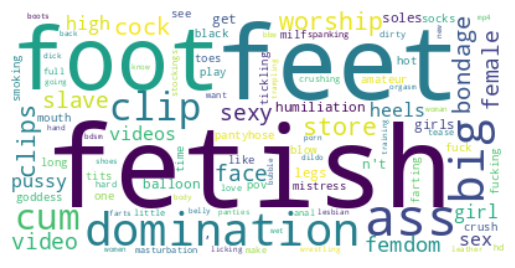

In [35]:
from wordcloud import *
word_freq = [i for i in words.most_common(100)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# Create dictionary ordered by frequency

Start from 2, because of

* 0 - code filler
* 1 - unknown word

In [36]:
word_to_index = dict()
index_to_word = dict()

In [37]:
max_words = 1000

In [38]:
for i, word in enumerate(words.most_common(max_words - 2)):
    word_to_index[word[0]] = i + 2
    index_to_word[i + 2] = word[0]

In [39]:
#word_to_index

In [40]:
#index_to_word

In [41]:
def text_to_sequence(txt, word_to_index):
    seq = []
    for word in txt:
        index = word_to_index.get(word, 1) # 1 - unknown word
        # Unknown words doesn't include to output sequence
        if index != 1:
            seq.append(index)
    return seq

In [42]:
txt = data['text_preprocessed'][10]

In [43]:
seq = [word_to_index.get(word, 1) for word in txt]

In [44]:
seq

[1, 1, 195, 15, 1, 440, 114, 10, 7]

In [45]:
index_to_word[16]

'face'

In [64]:
data['sequences'] = data.apply(lambda row: text_to_sequence(row['text_preprocessed'], word_to_index), axis=1)
data = data[['text_preprocessed', 'sequences', 'labels', 'text']] # columns reorder

In [65]:
data.head()

,text_preprocessed,sequences,labels,text
0,"[favorite, slut]","[831, 119]",0,My Favorite Slut
1,"[girlfriends, sit, faces, asses]","[419, 920]",0,girlfriends sit on each other's faces with the...
2,"[bound, beauty, kisses, girlfriend]","[130, 587, 927, 646]",0,bound beauty kisses her girlfriend
3,"[morgan, anytime, nail, painting, slave, face]","[716, 17, 16]",0,MORGAN - Anytime - Nail Painting On The Slave'...
4,"[transgender, coaching, 1]",[214],0,TRANSGENDER COACHING (wmv) PART 1


# Make the bag of words

In [48]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for index in sequence:
            results[i, index] += 1.
    return results

In [49]:
vactors = vectorize_sequences(data['sequences'], max_words)

# Word2Vec learn

In [50]:
import gensim.models

In [51]:
t = time()

# Creating model
cores = multiprocessing.cpu_count()

w2v_model = gensim.models.Word2Vec(data['text_preprocessed'],
                               min_count=1,
                               window=2,
                               sample=6e-5, 
                               alpha=0.03,
                               min_alpha=0.0007,
                               negative=20,
                               workers=cores-1)

# min_count=2 - how many times word in set

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.22 mins


In [52]:
w2v_model.build_vocab(data['text_preprocessed'], progress_per=1000)

In [53]:
t = time()

w2v_model.train(data['text_preprocessed'], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 1.23 mins


In [54]:
w2v_model.wv['abuse']

array([-1.8867657 ,  1.119586  ,  0.390685  , -1.16232   , -0.55083   ,
        0.7432118 ,  0.16632979,  0.88675904,  0.37930167,  1.3763039 ,
        0.3704463 ,  0.01839263,  1.450705  , -0.4701571 ,  0.19956353,
        0.41635162, -0.06979465, -1.8293684 , -0.56738335,  1.4811337 ,
       -1.3689082 ,  0.87622225, -1.3248402 , -0.17816323, -0.56958634,
       -0.5947061 ,  0.5400235 , -0.8453196 ,  0.3666421 ,  0.66856897,
        1.6945719 ,  0.50108176,  0.81779385, -0.2734903 , -1.0895284 ,
       -0.21902256, -0.32230732, -1.6802348 ,  0.10376228,  0.32342213,
       -1.5513959 , -1.375376  , -0.83361596, -0.30651274,  0.8311414 ,
        1.2247326 ,  0.25366887,  0.10080642,  1.8837777 , -2.341603  ,
        0.57569915, -0.12721184, -0.03592902, -0.23116745,  1.0145574 ,
        2.2387414 ,  1.0330845 , -0.8527219 , -0.3263275 ,  0.22186165,
       -0.04660278, -0.5501352 , -0.1100439 ,  0.5322907 , -0.9125056 ,
        0.6371345 , -0.11253361,  2.5528438 ,  1.1431557 , -1.40

In [55]:
w2v_model.wv.most_similar('rape')

[('kidnapping', 0.6702443361282349),
 ('forcedsex', 0.653887152671814),
 ('raped', 0.5569866895675659),
 ('footrape', 0.5392628312110901),
 ('sceneing', 0.5260156989097595),
 ('bondge', 0.4898975193500519),
 ('bagging', 0.48762771487236023),
 ('-sucking', 0.4780133366584778),
 ('masturabtion', 0.47705793380737305),
 ('cropping', 0.4508412182331085)]

# Model saving

In [56]:
w2v_model.save('../models/word2vec-80k.model')

# Model loading

In [57]:
new_w2v_model = gensim.models.Word2Vec.load('../models/word2vec-80k.model')

In [58]:
new_w2v_model.wv.most_similar('slut')

[('whore', 0.7314648032188416),
 ('submissive', 0.7129039168357849),
 ('sissy', 0.6985717415809631),
 ('sluts', 0.6472768187522888),
 ('cocksucking', 0.590284526348114),
 ('cocksucker', 0.5762284398078918),
 ('training', 0.5594162940979004),
 ('fuck', 0.5509209632873535),
 ('wife', 0.5499884486198425),
 ('cock', 0.5402417182922363)]

In [62]:
new_w2v_model.wv.similarity(w1="raped", w2="forcedsex")

0.4889322